In [1]:
## Notebook env: gedi (R kernel)
## GEDI pt.2 - runs GEDI to find spliced/unspliced ratio of genes across perturbations

## get the unspliced and spliced counts mtxs for each of tRF_1, tRF_2, tRF_3
## combine all unspliced mtxs and alle spliced mtxs into two final mtxs (save with scanpy)
## read into R the two mtxs with scrattch.io::read_loom_dgCMatrix, input into gedi

## then take imputed psi values (spliced/unspliced counts -- RNA stability) from gedi model and make violin plots of them as drawn in RM2

In [2]:
.libPaths('/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

## install packages below into env if not already installed
## remotes::install_github('csglab/GEDI', lib = '/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

library(HDF5Array)
library(ggplot2)
library(Matrix)
library(RColorBrewer)
library(uwot)
library(GEDI)
library(SeuratWrappers)
set.seed(43)

Loading required package: DelayedArray



Loading required package: stats4



Loading required package: Matrix



Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: MatrixGenerics



Loading required package: matrixStats




Attaching package: ‘MatrixGenerics’




The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeig

Loading required package: S4Vectors




Attaching package: ‘S4Vectors’




The following objects are masked from ‘package:Matrix’:

    expand, unname




The following object is masked from ‘package:utils’:

    findMatches




The following objects are masked from ‘package:base’:

    expand.grid, I, unname




Loading required package: IRanges



Loading required package: S4Arrays



Loading required package: abind




Attaching package: ‘S4Arrays’




The following object is masked from ‘package:abind’:

    abind




The following object is masked from ‘package:base’:

    rowsum




Loading required package: SparseArray




Attaching package: ‘DelayedArray’




The following objects are masked from ‘package:base’:

    apply, scale, sweep




Loading required package: rhdf5




Attaching package: ‘HDF5Array’




The following object is masked from ‘package:rhdf5’:

    h5ls




In [3]:
## load loom files
tRF_1 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/tRF_1/tRF_1.loom')
tRF_2 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/tRF_2/tRF_2.loom')
tRF_3 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/tRF_3/tRF_3.loom')

In [4]:
spliced = list(tRF_1[['spliced']], tRF_2[['spliced']], tRF_3[['spliced']])
unspliced = list(tRF_1[['unspliced']], tRF_2[['unspliced']], tRF_3[['unspliced']])

In [5]:
## combine spliced and unspliced counts into two final mtxs
## the gedi model will take sample labels within each of the two mtxs
spliced_combined = cbind(spliced[[1]], spliced[[2]], spliced[[3]])
unspliced_combined = cbind(unspliced[[1]], unspliced[[2]], unspliced[[3]])

## filter out genes with low median UMIs from the expression data
filtered_meta_data <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_meta.csv', header = TRUE)
rownames(filtered_meta_data) <- filtered_meta_data$X
filtered_meta_data$guide <- as.character(filtered_meta_data$guide)

raw_genes <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_gene_names.csv', header = FALSE)
raw_genes <- raw_genes$V2[-1]
raw_genes <- as.character(raw_genes)

filtered_raw_mtx <- readMM('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_normalized_data.mtx')
filtered_raw_mtx = as(filtered_raw_mtx, 'dgCMatrix')
rownames(filtered_raw_mtx) = raw_genes
colnames(filtered_raw_mtx) = rownames(filtered_meta_data)
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
genes_to_keep = as.numeric(medians) >= 0.01
filtered_raw_mtx <- filtered_raw_mtx[genes_to_keep,]

spliced_combined = spliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(spliced_combined)],]
unspliced_combined = unspliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(unspliced_combined)],]

## filter out low splice/unspliced count cells and low count genes
filtered_cols <- which(log10(colSums(spliced_combined)) > 3 & log10(colSums(unspliced_combined)) > 3)
filtered_rows <- which(rowSums(spliced_combined) > 50 & rowSums(unspliced_combined) > 50)
spliced_combined = spliced_combined[filtered_rows, filtered_cols]
unspliced_combined = unspliced_combined[filtered_rows, filtered_cols]

## get sample identity
sample_identity = stringr::str_sub(colnames(spliced_combined), start = 1, end = 5)


'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [6]:
## percent of cells that remain after filtering
100*length(filtered_cols) / ncol(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

## percent of genes that remain after filtering
100*length(filtered_rows) / nrow(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

[1] 90.13953

[1] 16.13344

Warning message:
“Removed 5773 rows containing non-finite outside the scale range (`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


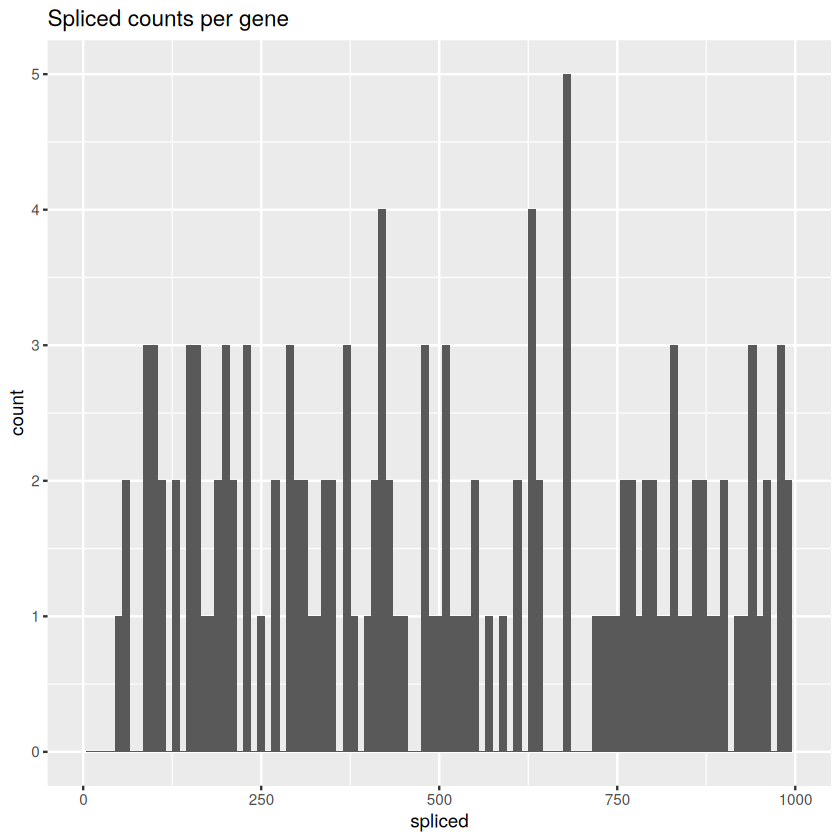

In [7]:
df = data.frame(spliced = rowSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 1000) + ggtitle('Spliced counts per gene')

Warning message:
“Removed 41475 rows containing non-finite outside the scale range
(`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


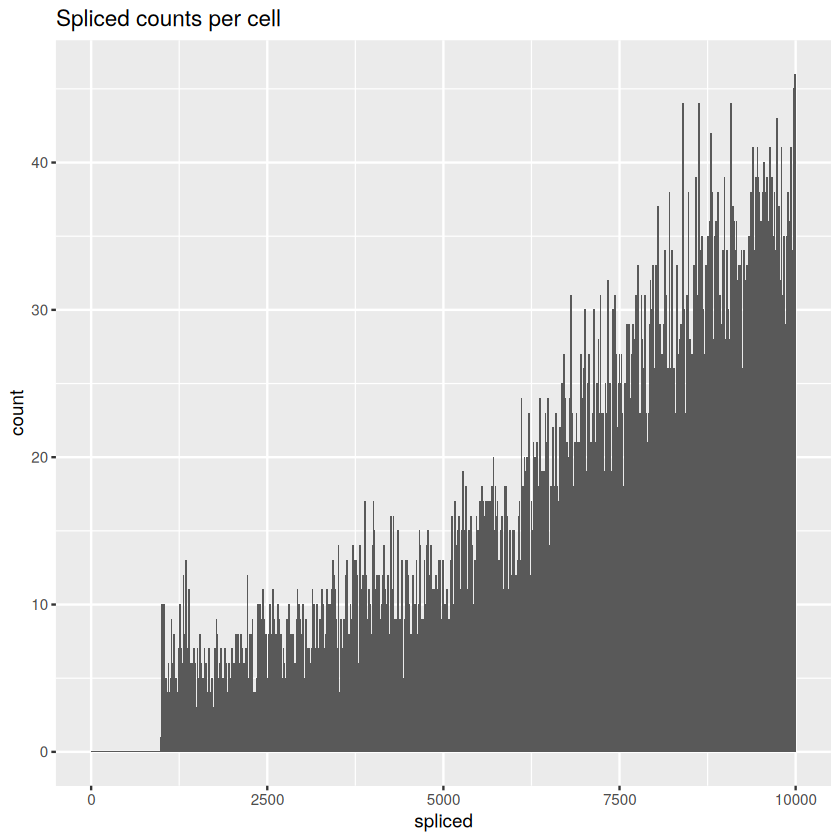

In [8]:
df2 = data.frame(spliced = colSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df2, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 10000) + ggtitle('Spliced counts per cell')

In [9]:
rm(tRF_1, tRF_2, tRF_3, spliced, unspliced, filtered_cols, filtered_rows, df, df2, filtered_raw_mtx)

In [10]:
## Set up GEDI model
model <- new("GEDI") # Initialize GEDI object
model$setup(Samples = sample_identity, # Vector indicating which sample belongs to each cell
            colData = data.frame(cell_names = colnames(spliced_combined)), # Metadata (optional)
            M = list(spliced_combined, unspliced_combined), # Expression data as a list of two matrices, in which case they are considered as paired observations whose log-ratio must be modelled.
            K = 20, # Number of latent variables to use
            mode = "Bsphere", # Modes to use: Either Bsphere (hyperellipsoid) or Bl2 (hyperplane)
            oi_shrinkage = 0.001 # Shrinkage multiplier for oi. In here we use 0.001, to better accommodated the mean abundance differences that exist between multiple scRNA-seq technologies.
            ) 
model$initialize.LVs(randomSeed = 1) # initialize LVs
model$optimize(iterations = 150) # run model with 150 iterations
saveRDS(model, file = "/home/ssobti/projects/mir_tud/output_data/splicing/tRF/tRF_gedi_model.rds") # Saving output model

Setting up the GEDI model...



Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


Initializing LVs...



  Initializing oi...



  Performing initial decompsition of Y...



Performing block coordinate descent optimization...



  Iteration 1/150 (total 1)...



2.798253 
1 
Mean(o): -0.4500432 ; Var(o): 1.70062 ; Var(si): 0.001648237 


  Iteration 2/150 (total 2)...



2.400923 
1 
Mean(o): -0.4501098 ; Var(o): 1.979317 ; Var(si): 0.003542524 


  Iteration 3/150 (total 3)...



2.124114 
1 
Mean(o): -0.4501587 ; Var(o): 2.234333 ; Var(si): 0.00587272 


  Iteration 4/150 (total 4)...



1.923803 
1 
Mean(o): -0.450198 ; Var(o): 2.463965 ; Var(si): 0.008472613 


  Iteration 5/150 (total 5)...



1.773449 
1 
Mean(o): -0.4502314 ; Var(o): 2.669858 ; Var(si): 0.01087258 


  Iteration 6/150 (total 6)...



1.654047 
1 
Mean(o): -0.4502615 ; Var(o): 2.85968 ; Var(si): 0.01260515 


  Iteration 7/150 (total 7)...



1.55132 
1 
Mean(o): -0.4502904 ; Var(o): 3.04628 ; Var(si): 0.01370759 


  Iteration 8/150 (total 8)...



1.457924 
1 
Mean(o): -0.4503192 ; Var(o): 3.238827 ; Var(si): 0.01434303 


  Iteration 9/150 (total 9)...



1.371029 
1 
Mean(o): -0.4503484 ; Var(o): 3.441671 ; Var(si): 0.01474198 


  Iteration 10/150 (total 10)...



1.289243 
1 
Mean(o): -0.4503782 ; Var(o): 3.657721 ; Var(si): 0.01519723 


  Iteration 11/150 (total 11)...



1.213096 
1 
Mean(o): -0.4504081 ; Var(o): 3.885158 ; Var(si): 0.01585811 


  Iteration 12/150 (total 12)...



1.143582 
1 
Mean(o): -0.4504376 ; Var(o): 4.119249 ; Var(si): 0.01671481 


  Iteration 13/150 (total 13)...



1.080931 
1 
Mean(o): -0.4504662 ; Var(o): 4.355979 ; Var(si): 0.01769199 


  Iteration 14/150 (total 14)...



1.024788 
1 
Mean(o): -0.4504938 ; Var(o): 4.592637 ; Var(si): 0.01870406 


  Iteration 15/150 (total 15)...



0.9745488 
1 
Mean(o): -0.4505203 ; Var(o): 4.827423 ; Var(si): 0.01968663 


  Iteration 16/150 (total 16)...



0.9295367 
1 
Mean(o): -0.450546 ; Var(o): 5.059221 ; Var(si): 0.0206103 


  Iteration 17/150 (total 17)...



0.8890885 
1 
Mean(o): -0.4505708 ; Var(o): 5.287414 ; Var(si): 0.02147425 


  Iteration 18/150 (total 18)...



0.8526013 
1 
Mean(o): -0.450595 ; Var(o): 5.511711 ; Var(si): 0.0222915 


  Iteration 19/150 (total 19)...



0.819548 
1 
Mean(o): -0.4506186 ; Var(o): 5.732015 ; Var(si): 0.02307761 


  Iteration 20/150 (total 20)...



0.7894766 
1 
Mean(o): -0.4506416 ; Var(o): 5.948346 ; Var(si): 0.02384543 


  Iteration 21/150 (total 21)...



0.7620037 
1 
Mean(o): -0.4506642 ; Var(o): 6.160791 ; Var(si): 0.02460365 


  Iteration 22/150 (total 22)...



0.7368045 
1 
Mean(o): -0.4506864 ; Var(o): 6.369468 ; Var(si): 0.02535735 


  Iteration 23/150 (total 23)...



0.7136047 
1 
Mean(o): -0.4507081 ; Var(o): 6.574506 ; Var(si): 0.02610896 


  Iteration 24/150 (total 24)...



0.6921719 
1 
Mean(o): -0.4507294 ; Var(o): 6.776033 ; Var(si): 0.02685928 


  Iteration 25/150 (total 25)...



0.6723085 
1 
Mean(o): -0.4507504 ; Var(o): 6.974171 ; Var(si): 0.02760822 


  Iteration 26/150 (total 26)...



0.6538456 
1 
Mean(o): -0.4507709 ; Var(o): 7.169034 ; Var(si): 0.02835525 


  Iteration 27/150 (total 27)...



0.6366378 
1 
Mean(o): -0.4507912 ; Var(o): 7.360726 ; Var(si): 0.02909972 


  Iteration 28/150 (total 28)...



0.6205596 
1 
Mean(o): -0.450811 ; Var(o): 7.549346 ; Var(si): 0.02984099 


  Iteration 29/150 (total 29)...



0.6055016 
1 
Mean(o): -0.4508306 ; Var(o): 7.734986 ; Var(si): 0.03057849 


  Iteration 30/150 (total 30)...



0.5913685 
1 
Mean(o): -0.4508499 ; Var(o): 7.917735 ; Var(si): 0.03131175 


  Iteration 31/150 (total 31)...



0.5780761 
1 
Mean(o): -0.4508688 ; Var(o): 8.097678 ; Var(si): 0.03204035 


  Iteration 32/150 (total 32)...



0.5655504 
1 
Mean(o): -0.4508875 ; Var(o): 8.274894 ; Var(si): 0.03276397 


  Iteration 33/150 (total 33)...



0.5537259 
1 
Mean(o): -0.450906 ; Var(o): 8.449462 ; Var(si): 0.03348232 


  Iteration 34/150 (total 34)...



0.5425443 
1 
Mean(o): -0.4509241 ; Var(o): 8.621456 ; Var(si): 0.0341952 


  Iteration 35/150 (total 35)...



0.5319535 
1 
Mean(o): -0.4509421 ; Var(o): 8.790948 ; Var(si): 0.03490243 


  Iteration 36/150 (total 36)...



0.5219071 
1 
Mean(o): -0.4509598 ; Var(o): 8.958006 ; Var(si): 0.03560387 


  Iteration 37/150 (total 37)...



0.5123634 
1 
Mean(o): -0.4509773 ; Var(o): 9.122696 ; Var(si): 0.03629943 


  Iteration 38/150 (total 38)...



0.5032848 
1 
Mean(o): -0.4509946 ; Var(o): 9.285081 ; Var(si): 0.03698904 


  Iteration 39/150 (total 39)...



0.4946375 
1 
Mean(o): -0.4510116 ; Var(o): 9.445221 ; Var(si): 0.03767265 


  Iteration 40/150 (total 40)...



0.4863908 
1 
Mean(o): -0.4510285 ; Var(o): 9.603176 ; Var(si): 0.03835025 


  Iteration 41/150 (total 41)...



0.4785168 
1 
Mean(o): -0.4510452 ; Var(o): 9.759001 ; Var(si): 0.03902183 


  Iteration 42/150 (total 42)...



0.4709903 
1 
Mean(o): -0.4510617 ; Var(o): 9.912751 ; Var(si): 0.03968741 


  Iteration 43/150 (total 43)...



0.4637883 
1 
Mean(o): -0.4510781 ; Var(o): 10.06448 ; Var(si): 0.04034702 


  Iteration 44/150 (total 44)...



0.4568897 
1 
Mean(o): -0.4510943 ; Var(o): 10.21423 ; Var(si): 0.04100069 


  Iteration 45/150 (total 45)...



0.4502752 
1 
Mean(o): -0.4511103 ; Var(o): 10.36206 ; Var(si): 0.04164847 


  Iteration 46/150 (total 46)...



0.4439273 
1 
Mean(o): -0.4511262 ; Var(o): 10.50802 ; Var(si): 0.04229041 


  Iteration 47/150 (total 47)...



0.4378297 
1 
Mean(o): -0.4511419 ; Var(o): 10.65214 ; Var(si): 0.04292656 


  Iteration 48/150 (total 48)...



0.4319675 
1 
Mean(o): -0.4511575 ; Var(o): 10.79448 ; Var(si): 0.04355698 


  Iteration 49/150 (total 49)...



0.426327 
1 
Mean(o): -0.451173 ; Var(o): 10.93507 ; Var(si): 0.04418173 


  Iteration 50/150 (total 50)...



0.4208956 
1 
Mean(o): -0.4511884 ; Var(o): 11.07395 ; Var(si): 0.04480084 


  Iteration 51/150 (total 51)...



0.4156615 
1 
Mean(o): -0.4512036 ; Var(o): 11.21116 ; Var(si): 0.04541439 


  Iteration 52/150 (total 52)...



0.4106141 
1 
Mean(o): -0.4512187 ; Var(o): 11.34675 ; Var(si): 0.04602242 


  Iteration 53/150 (total 53)...



0.4057431 
1 
Mean(o): -0.4512336 ; Var(o): 11.48073 ; Var(si): 0.04662499 


  Iteration 54/150 (total 54)...



0.4010395 
1 
Mean(o): -0.4512485 ; Var(o): 11.61315 ; Var(si): 0.04722218 


  Iteration 55/150 (total 55)...



0.3964946 
1 
Mean(o): -0.4512633 ; Var(o): 11.74403 ; Var(si): 0.04781402 


  Iteration 56/150 (total 56)...



0.3921004 
1 
Mean(o): -0.4512779 ; Var(o): 11.87341 ; Var(si): 0.04840059 


  Iteration 57/150 (total 57)...



0.3878493 
1 
Mean(o): -0.4512925 ; Var(o): 12.00131 ; Var(si): 0.04898193 


  Iteration 58/150 (total 58)...



0.3837343 
1 
Mean(o): -0.4513069 ; Var(o): 12.12777 ; Var(si): 0.0495581 


  Iteration 59/150 (total 59)...



0.3797491 
1 
Mean(o): -0.4513213 ; Var(o): 12.2528 ; Var(si): 0.05012915 


  Iteration 60/150 (total 60)...



0.3758873 
1 
Mean(o): -0.4513356 ; Var(o): 12.37645 ; Var(si): 0.05069513 


  Iteration 61/150 (total 61)...



0.3721433 
1 
Mean(o): -0.4513498 ; Var(o): 12.49872 ; Var(si): 0.05125609 


  Iteration 62/150 (total 62)...



0.3685118 
1 
Mean(o): -0.4513638 ; Var(o): 12.61965 ; Var(si): 0.05181206 


  Iteration 63/150 (total 63)...



0.3649875 
1 
Mean(o): -0.4513779 ; Var(o): 12.73926 ; Var(si): 0.05236311 


  Iteration 64/150 (total 64)...



0.3615658 
1 
Mean(o): -0.4513918 ; Var(o): 12.85758 ; Var(si): 0.05290928 


  Iteration 65/150 (total 65)...



0.3582422 
1 
Mean(o): -0.4514056 ; Var(o): 12.97462 ; Var(si): 0.05345061 


  Iteration 66/150 (total 66)...



0.3550124 
1 
Mean(o): -0.4514194 ; Var(o): 13.09041 ; Var(si): 0.05398716 


  Iteration 67/150 (total 67)...



0.3518725 
1 
Mean(o): -0.4514331 ; Var(o): 13.20498 ; Var(si): 0.05451899 


  Iteration 68/150 (total 68)...



0.3488187 
1 
Mean(o): -0.4514468 ; Var(o): 13.31834 ; Var(si): 0.05504613 


  Iteration 69/150 (total 69)...



0.3458474 
1 
Mean(o): -0.4514603 ; Var(o): 13.43052 ; Var(si): 0.05556865 


  Iteration 70/150 (total 70)...



0.3429553 
1 
Mean(o): -0.4514738 ; Var(o): 13.54154 ; Var(si): 0.0560866 


  Iteration 71/150 (total 71)...



0.3401392 
1 
Mean(o): -0.4514873 ; Var(o): 13.65141 ; Var(si): 0.05660003 


  Iteration 72/150 (total 72)...



0.337396 
1 
Mean(o): -0.4515006 ; Var(o): 13.76015 ; Var(si): 0.057109 


  Iteration 73/150 (total 73)...



0.334723 
1 
Mean(o): -0.4515139 ; Var(o): 13.8678 ; Var(si): 0.05761357 


  Iteration 74/150 (total 74)...



0.3321173 
1 
Mean(o): -0.4515272 ; Var(o): 13.97436 ; Var(si): 0.05811379 


  Iteration 75/150 (total 75)...



0.3295765 
1 
Mean(o): -0.4515404 ; Var(o): 14.07985 ; Var(si): 0.05860972 


  Iteration 76/150 (total 76)...



0.327098 
1 
Mean(o): -0.4515535 ; Var(o): 14.18429 ; Var(si): 0.0591014 


  Iteration 77/150 (total 77)...



0.3246796 
1 
Mean(o): -0.4515666 ; Var(o): 14.2877 ; Var(si): 0.05958891 


  Iteration 78/150 (total 78)...



0.3223191 
1 
Mean(o): -0.4515796 ; Var(o): 14.3901 ; Var(si): 0.06007228 


  Iteration 79/150 (total 79)...



0.3200144 
1 
Mean(o): -0.4515926 ; Var(o): 14.4915 ; Var(si): 0.06055158 


  Iteration 80/150 (total 80)...



0.3177634 
1 
Mean(o): -0.4516055 ; Var(o): 14.59192 ; Var(si): 0.06102685 


  Iteration 81/150 (total 81)...



0.3155643 
1 
Mean(o): -0.4516184 ; Var(o): 14.69137 ; Var(si): 0.06149815 


  Iteration 82/150 (total 82)...



0.3134153 
1 
Mean(o): -0.4516312 ; Var(o): 14.78987 ; Var(si): 0.06196553 


  Iteration 83/150 (total 83)...



0.3113146 
1 
Mean(o): -0.451644 ; Var(o): 14.88744 ; Var(si): 0.06242905 


  Iteration 84/150 (total 84)...



0.3092606 
1 
Mean(o): -0.4516567 ; Var(o): 14.98409 ; Var(si): 0.06288874 


  Iteration 85/150 (total 85)...



0.3072517 
1 
Mean(o): -0.4516694 ; Var(o): 15.07983 ; Var(si): 0.06334466 


  Iteration 86/150 (total 86)...



0.3052864 
1 
Mean(o): -0.451682 ; Var(o): 15.17468 ; Var(si): 0.06379687 


  Iteration 87/150 (total 87)...



0.3033632 
1 
Mean(o): -0.4516946 ; Var(o): 15.26865 ; Var(si): 0.06424539 


  Iteration 88/150 (total 88)...



0.3014809 
1 
Mean(o): -0.4517072 ; Var(o): 15.36176 ; Var(si): 0.06469029 


  Iteration 89/150 (total 89)...



0.2996381 
1 
Mean(o): -0.4517197 ; Var(o): 15.45402 ; Var(si): 0.06513161 


  Iteration 90/150 (total 90)...



0.2978335 
1 
Mean(o): -0.4517322 ; Var(o): 15.54544 ; Var(si): 0.06556939 


  Iteration 91/150 (total 91)...



0.2960659 
1 
Mean(o): -0.4517446 ; Var(o): 15.63603 ; Var(si): 0.06600368 


  Iteration 92/150 (total 92)...



0.2943342 
1 
Mean(o): -0.451757 ; Var(o): 15.72581 ; Var(si): 0.06643452 


  Iteration 93/150 (total 93)...



0.2926373 
1 
Mean(o): -0.4517694 ; Var(o): 15.81479 ; Var(si): 0.06686195 


  Iteration 94/150 (total 94)...



0.2909741 
1 
Mean(o): -0.4517817 ; Var(o): 15.90297 ; Var(si): 0.06728602 


  Iteration 95/150 (total 95)...



0.2893436 
1 
Mean(o): -0.451794 ; Var(o): 15.99038 ; Var(si): 0.06770677 


  Iteration 96/150 (total 96)...



0.2877448 
1 
Mean(o): -0.4518062 ; Var(o): 16.07703 ; Var(si): 0.06812423 


  Iteration 97/150 (total 97)...



0.2861768 
1 
Mean(o): -0.4518185 ; Var(o): 16.16292 ; Var(si): 0.06853845 


  Iteration 98/150 (total 98)...



0.2846387 
1 
Mean(o): -0.4518306 ; Var(o): 16.24806 ; Var(si): 0.06894946 


  Iteration 99/150 (total 99)...



0.2831296 
1 
Mean(o): -0.4518428 ; Var(o): 16.33247 ; Var(si): 0.06935731 


  Iteration 100/150 (total 100)...



0.2816487 
1 
Mean(o): -0.4518549 ; Var(o): 16.41615 ; Var(si): 0.06976204 


  Iteration 101/150 (total 101)...



0.2801952 
1 
Mean(o): -0.451867 ; Var(o): 16.49912 ; Var(si): 0.07016367 


  Iteration 102/150 (total 102)...



0.2787683 
1 
Mean(o): -0.4518791 ; Var(o): 16.58139 ; Var(si): 0.07056225 


  Iteration 103/150 (total 103)...



0.2773673 
1 
Mean(o): -0.4518911 ; Var(o): 16.66296 ; Var(si): 0.07095782 


  Iteration 104/150 (total 104)...



0.2759915 
1 
Mean(o): -0.4519031 ; Var(o): 16.74385 ; Var(si): 0.0713504 


  Iteration 105/150 (total 105)...



0.2746401 
1 
Mean(o): -0.4519151 ; Var(o): 16.82406 ; Var(si): 0.07174004 


  Iteration 106/150 (total 106)...



0.2733126 
1 
Mean(o): -0.451927 ; Var(o): 16.9036 ; Var(si): 0.07212677 


  Iteration 107/150 (total 107)...



0.2720083 
1 
Mean(o): -0.4519389 ; Var(o): 16.98249 ; Var(si): 0.07251061 


  Iteration 108/150 (total 108)...



0.2707265 
1 
Mean(o): -0.4519508 ; Var(o): 17.06073 ; Var(si): 0.07289162 


  Iteration 109/150 (total 109)...



0.2694667 
1 
Mean(o): -0.4519627 ; Var(o): 17.13833 ; Var(si): 0.07326981 


  Iteration 110/150 (total 110)...



0.2682284 
1 
Mean(o): -0.4519745 ; Var(o): 17.21529 ; Var(si): 0.07364522 


  Iteration 111/150 (total 111)...



0.2670109 
1 
Mean(o): -0.4519863 ; Var(o): 17.29164 ; Var(si): 0.07401789 


  Iteration 112/150 (total 112)...



0.2658137 
1 
Mean(o): -0.4519981 ; Var(o): 17.36736 ; Var(si): 0.07438783 


  Iteration 113/150 (total 113)...



0.2646363 
1 
Mean(o): -0.4520099 ; Var(o): 17.44249 ; Var(si): 0.0747551 


  Iteration 114/150 (total 114)...



0.2634782 
1 
Mean(o): -0.4520216 ; Var(o): 17.51701 ; Var(si): 0.0751197 


  Iteration 115/150 (total 115)...



0.262339 
1 
Mean(o): -0.4520334 ; Var(o): 17.59094 ; Var(si): 0.07548169 


  Iteration 116/150 (total 116)...



0.2612181 
1 
Mean(o): -0.452045 ; Var(o): 17.66428 ; Var(si): 0.07584107 


  Iteration 117/150 (total 117)...



0.2601152 
1 
Mean(o): -0.4520567 ; Var(o): 17.73705 ; Var(si): 0.07619789 


  Iteration 118/150 (total 118)...



0.2590297 
1 
Mean(o): -0.4520684 ; Var(o): 17.80925 ; Var(si): 0.07655217 


  Iteration 119/150 (total 119)...



0.2579613 
1 
Mean(o): -0.45208 ; Var(o): 17.88089 ; Var(si): 0.07690394 


  Iteration 120/150 (total 120)...



0.2569096 
1 
Mean(o): -0.4520916 ; Var(o): 17.95197 ; Var(si): 0.07725322 


  Iteration 121/150 (total 121)...



0.2558741 
1 
Mean(o): -0.4521032 ; Var(o): 18.02251 ; Var(si): 0.07760005 


  Iteration 122/150 (total 122)...



0.2548545 
1 
Mean(o): -0.4521147 ; Var(o): 18.0925 ; Var(si): 0.07794445 


  Iteration 123/150 (total 123)...



0.2538504 
1 
Mean(o): -0.4521263 ; Var(o): 18.16196 ; Var(si): 0.07828645 


  Iteration 124/150 (total 124)...



0.2528615 
1 
Mean(o): -0.4521378 ; Var(o): 18.23089 ; Var(si): 0.07862607 


  Iteration 125/150 (total 125)...



0.2518874 
1 
Mean(o): -0.4521493 ; Var(o): 18.29929 ; Var(si): 0.07896334 


  Iteration 126/150 (total 126)...



0.2509277 
1 
Mean(o): -0.4521608 ; Var(o): 18.36719 ; Var(si): 0.07929829 


  Iteration 127/150 (total 127)...



0.2499822 
1 
Mean(o): -0.4521722 ; Var(o): 18.43457 ; Var(si): 0.07963093 


  Iteration 128/150 (total 128)...



0.2490505 
1 
Mean(o): -0.4521837 ; Var(o): 18.50144 ; Var(si): 0.07996129 


  Iteration 129/150 (total 129)...



0.2481323 
1 
Mean(o): -0.4521951 ; Var(o): 18.56783 ; Var(si): 0.08028941 


  Iteration 130/150 (total 130)...



0.2472274 
1 
Mean(o): -0.4522065 ; Var(o): 18.63371 ; Var(si): 0.08061529 


  Iteration 131/150 (total 131)...



0.2463354 
1 
Mean(o): -0.4522179 ; Var(o): 18.69912 ; Var(si): 0.08093897 


  Iteration 132/150 (total 132)...



0.2454561 
1 
Mean(o): -0.4522293 ; Var(o): 18.76404 ; Var(si): 0.08126046 


  Iteration 133/150 (total 133)...



0.2445891 
1 
Mean(o): -0.4522406 ; Var(o): 18.82849 ; Var(si): 0.08157979 


  Iteration 134/150 (total 134)...



0.2437343 
1 
Mean(o): -0.452252 ; Var(o): 18.89247 ; Var(si): 0.08189699 


  Iteration 135/150 (total 135)...



0.2428913 
1 
Mean(o): -0.4522633 ; Var(o): 18.95598 ; Var(si): 0.08221207 


  Iteration 136/150 (total 136)...



0.2420599 
1 
Mean(o): -0.4522746 ; Var(o): 19.01904 ; Var(si): 0.08252506 


  Iteration 137/150 (total 137)...



0.2412399 
1 
Mean(o): -0.4522859 ; Var(o): 19.08165 ; Var(si): 0.08283597 


  Iteration 138/150 (total 138)...



0.240431 
1 
Mean(o): -0.4522972 ; Var(o): 19.1438 ; Var(si): 0.08314483 


  Iteration 139/150 (total 139)...



0.2396331 
1 
Mean(o): -0.4523084 ; Var(o): 19.20551 ; Var(si): 0.08345166 


  Iteration 140/150 (total 140)...



0.2388458 
1 
Mean(o): -0.4523196 ; Var(o): 19.26679 ; Var(si): 0.08375648 


  Iteration 141/150 (total 141)...



0.238069 
1 
Mean(o): -0.4523309 ; Var(o): 19.32763 ; Var(si): 0.0840593 


  Iteration 142/150 (total 142)...



0.2373024 
1 
Mean(o): -0.4523421 ; Var(o): 19.38805 ; Var(si): 0.08436016 


  Iteration 143/150 (total 143)...



0.2365459 
1 
Mean(o): -0.4523533 ; Var(o): 19.44804 ; Var(si): 0.08465906 


  Iteration 144/150 (total 144)...



0.2357993 
1 
Mean(o): -0.4523645 ; Var(o): 19.50761 ; Var(si): 0.08495604 


  Iteration 145/150 (total 145)...



0.2350623 
1 
Mean(o): -0.4523756 ; Var(o): 19.56677 ; Var(si): 0.0852511 


  Iteration 146/150 (total 146)...



0.2343347 
1 
Mean(o): -0.4523868 ; Var(o): 19.62551 ; Var(si): 0.08554426 


  Iteration 147/150 (total 147)...



0.2336165 
1 
Mean(o): -0.4523979 ; Var(o): 19.68386 ; Var(si): 0.08583555 


  Iteration 148/150 (total 148)...



0.2329073 
1 
Mean(o): -0.452409 ; Var(o): 19.7418 ; Var(si): 0.08612498 


  Iteration 149/150 (total 149)...



0.2322071 
1 
Mean(o): -0.4524202 ; Var(o): 19.79934 ; Var(si): 0.08641257 


  Iteration 150/150 (total 150)...



0.2315156 
1 
Mean(o): -0.4524312 ; Var(o): 19.8565 ; Var(si): 0.08669834 


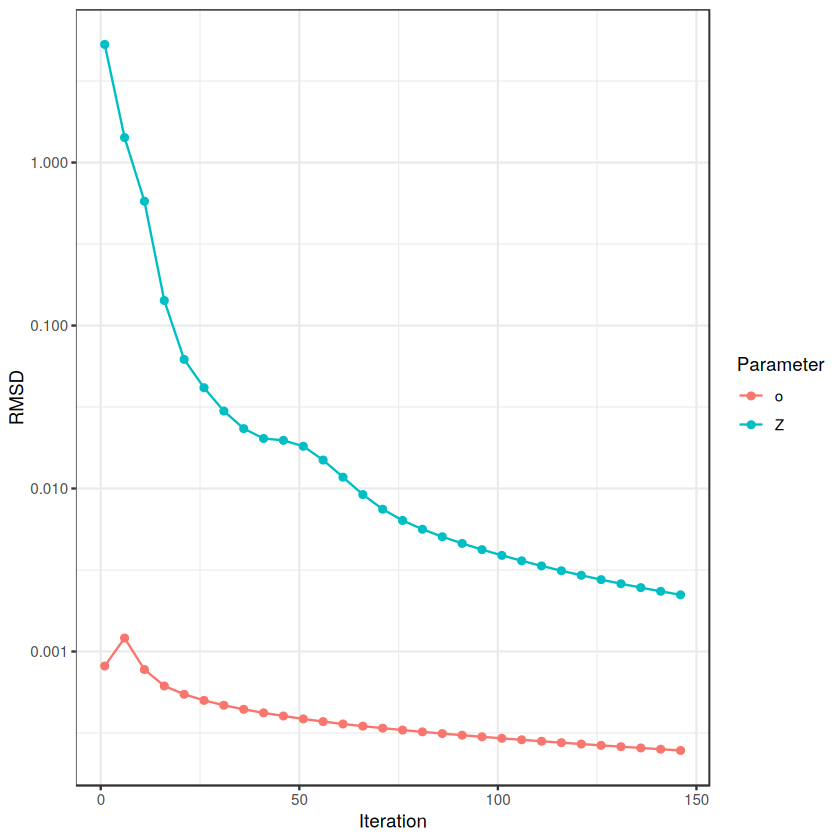

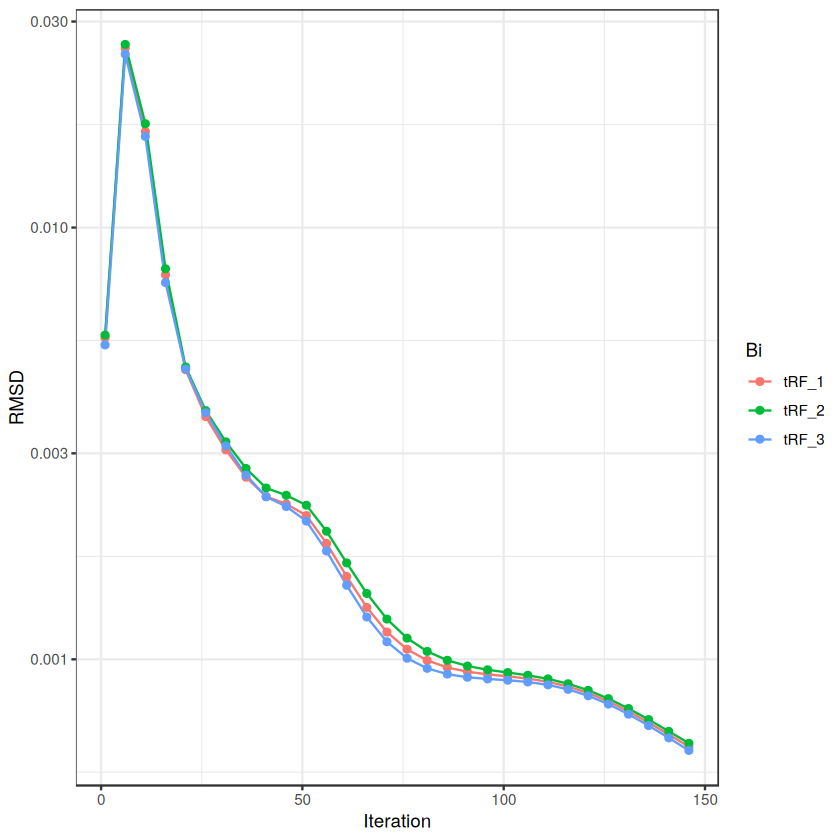

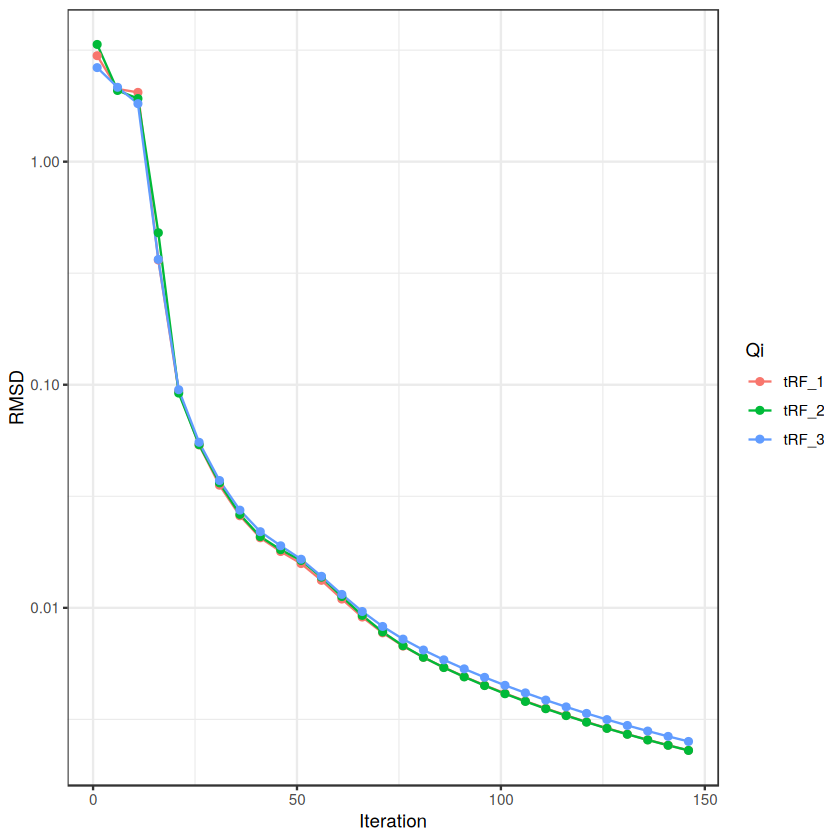

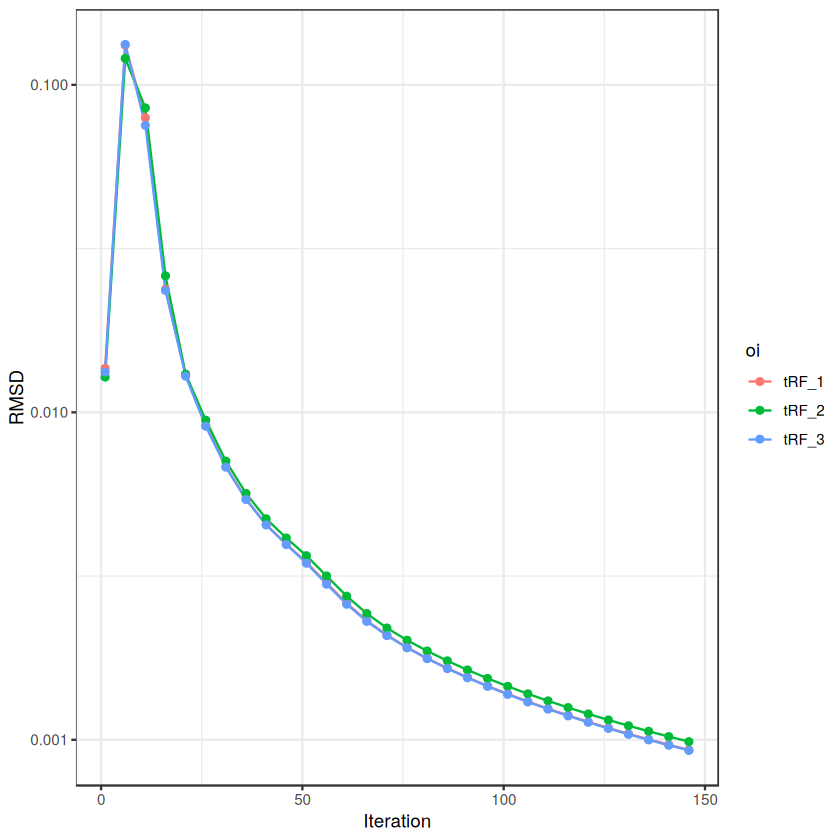

$ZAo

$Bi

$Qi

$oi

$si

$Rk
NULL

$sigma2


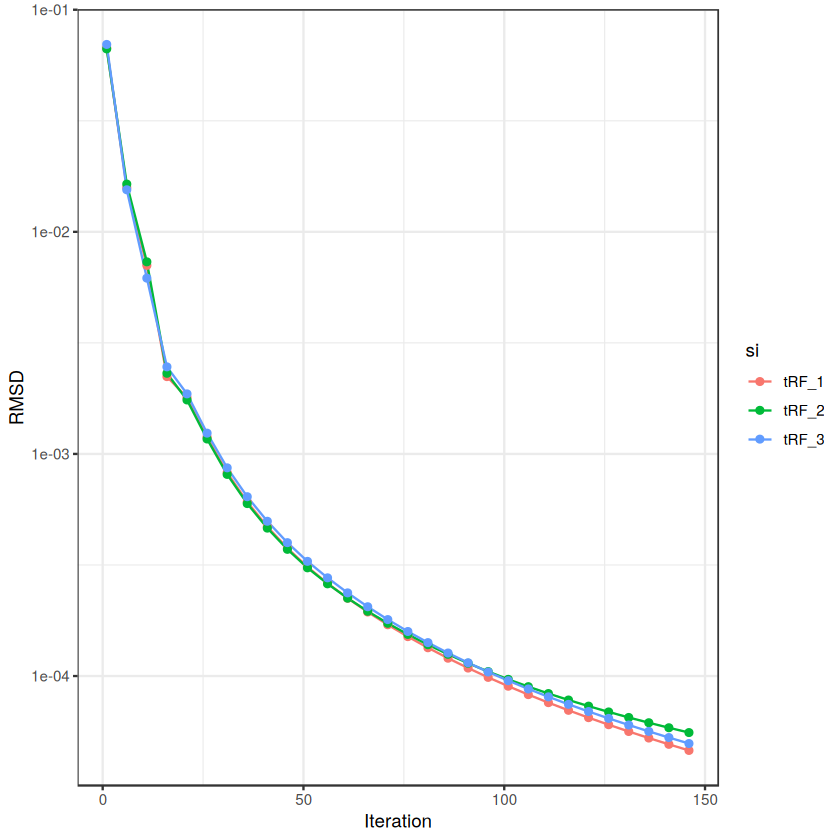

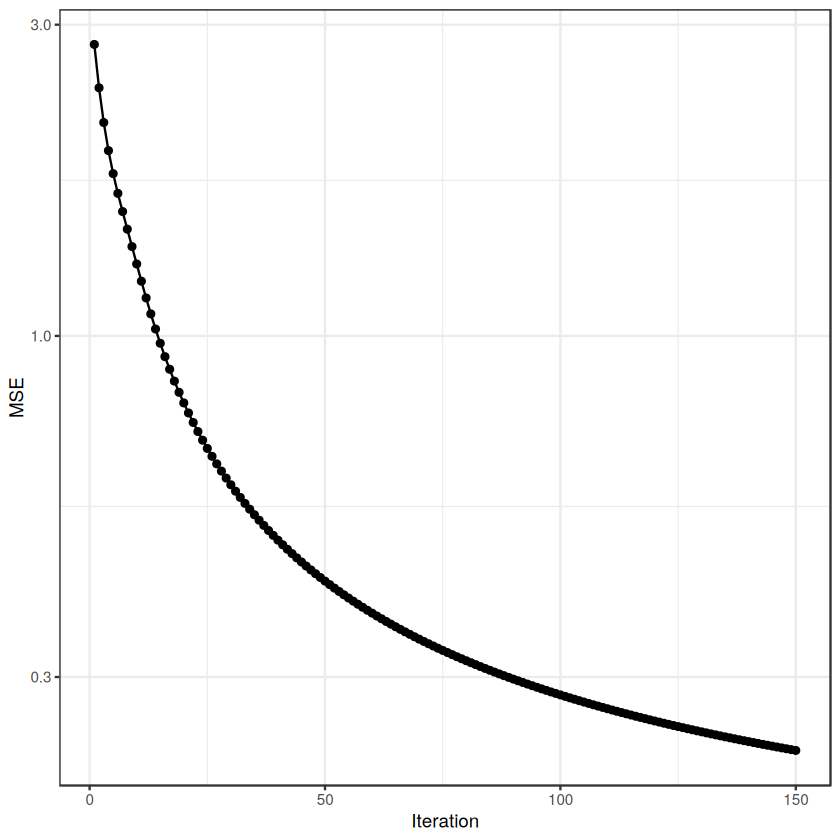

In [11]:
model$plotTracking()